In [2]:
import numpy as np
import pandas as pd
from scipy.fftpack import dct
from scipy.stats import kurtosis, skew, entropy
from skimage.util import view_as_blocks
from skimage import color, transform, io
import matplotlib.pyplot as plt
from skimage.data import camera, astronaut, coffee, coins, text, moon, page

sample_images = [camera(), astronaut(), coffee(), coins(), text(), moon(), page()]
images = []
for img in sample_images[:10]:
    if img.ndim == 3:
        img = color.rgb2gray(img)
    img_resized = transform.resize(img, (64, 64), anti_aliasing=True)
    images.append((img_resized * 255).astype(np.uint8))
#  2D DCT to an 8x8 block
def block_dct(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')
#  extract features from an image
def extract_features(image):
    blocks = view_as_blocks(image, block_shape=(8, 8))
    blocks = blocks.reshape(-1, 8, 8)
    R1_stats, R2_stats, R3_stats = [], [], []
    for block in blocks:
        dct_block = block_dct(block)
        R1 = dct_block[0:4, 0:4].flatten() # Define regions
        R2 = np.concatenate((dct_block[0:4, 4:8].flatten(), dct_block[4:8, 0:4].flatten()))
        R3 = dct_block[4:8, 4:8].flatten()
        for region, stats_list in zip([R1, R2, R3], [R1_stats, R2_stats, R3_stats]):
            ac = region.copy()
            if len(ac) > 0:
                stats = {
                    'mean': np.mean(ac),
                    'variance': np.var(ac),
                    'kurtosis': kurtosis(ac),
                    'skewness': skew(ac),
                    'entropy': entropy(np.abs(ac) / np.sum(np.abs(ac)) + 1e-12),
                    'energy': np.sum(ac ** 2)}
            else:
                stats = dict(mean=0, variance=0, kurtosis=0, skewness=0, entropy=0, energy=0)
            stats_list.append(stats)
    features = []
    for stats_list in [R1_stats, R2_stats, R3_stats]:
        avg_stats = {k: np.mean([s[k] for s in stats_list]) for k in stats_list[0]}
        features.extend([avg_stats['mean'], avg_stats['variance'], avg_stats['kurtosis'],
                         avg_stats['skewness'], avg_stats['entropy'], avg_stats['energy']])
    return features
all_features = [extract_features(img) for img in images]  # Extract features for all images
columns = []
for region in ['R1', 'R2', 'R3']:
    for stat in ['mean', 'variance', 'kurtosis', 'skewness', 'entropy', 'energy']:
        columns.append(f"{region}_{stat}")


CSV file saved as dct_descriptor_vectors.csv


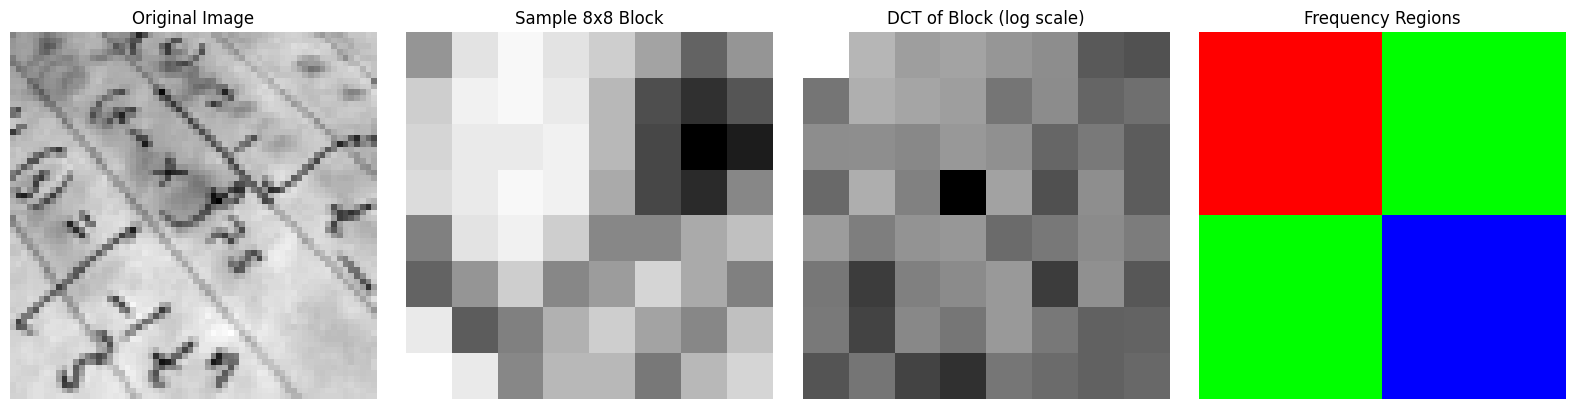

In [3]:
df = pd.DataFrame(all_features, columns=columns)
csv_file = "dct_descriptor_vectors.csv"
df.to_csv(csv_file, index=False)
print(f"CSV file saved as {csv_file}")
example_img = images[4]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(example_img, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')

# Sample block
blocks = view_as_blocks(example_img, block_shape=(8, 8))
blocks = blocks.reshape(-1, 8, 8)
block_example = blocks[0]
axs[1].imshow(block_example, cmap='gray')
axs[1].set_title("Sample 8x8 Block")
axs[1].axis('off')

# DCT of the block
dct_block_example = block_dct(block_example)
axs[2].imshow(np.log(np.abs(dct_block_example) + 1e-12), cmap='gray')
axs[2].set_title("DCT of Block (log scale)")
axs[2].axis('off')

region_img = np.zeros((8, 8, 3), dtype=np.uint8)
region_img[0:4, 0:4] = [255, 0, 0]   # R1 - Red
region_img[0:4, 4:8] = [0, 255, 0]   # R2 - Green part 1
region_img[4:8, 0:4] = [0, 255, 0]   # R2 - Green part 2
region_img[4:8, 4:8] = [0, 0, 255]   # R3 - Blue
axs[3].imshow(region_img)
axs[3].set_title("Frequency Regions")
axs[3].axis('off')
plt.tight_layout()
plt.show()
